In [1]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing
import nltk
import csv
import networkx as nx
import operator
import matplotlib.pyplot as plt
import pandas as pd
import re

##### loading the data

In [2]:
nltk.download('punkt') # for tokenization
nltk.download('stopwords')
stpwds = set(nltk.corpus.stopwords.words("english"))
stemmer = nltk.stem.PorterStemmer()

with open("testing_set.txt", "r") as f:
    reader = csv.reader(f)
    testing_set  = list(reader)

testing_set = [element[0].split(" ") for element in testing_set]

with open("training_set.txt", "r") as f:
    reader = csv.reader(f)
    training_set  = list(reader)

training_set = [element[0].split(" ") for element in training_set]

with open("node_information.csv", "r") as f:
    reader = csv.reader(f)
    node_info  = list(reader)

IDs = [element[0] for element in node_info]

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kingr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kingr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


##### Graph features computation on authors and articles

##### one might want to add the option of a directed link only if the temporal difference allows us todo so

In [3]:
def graph_articles(citation_set, node_info, directed_or_not = 'n'):
    if directed_or_not == 'y':
        G = nx.DiGraph()
    else:
        G = nx.Graph()
    for node in node_info:
        G.add_node(node[0], year = node[1])
    for i in citation_set:
        if i[2] == '1':
            if G.node[i[0]]['year'] < G.node[i[1]]['year']:
                G.add_edge(i[0], i[1])
            else:
                G.add_edge(i[1], i[0])
    return G

In [4]:
def graph_authors(citation_set, node_info, IDs, directed_or_not = 'n'):
    if directed_or_not == 'y':
        G = nx.DiGraph()
    else:
        G = nx.Graph()
    
    counter = 0
    for citation in citation_set:
        source = citation[0]
        target = citation[1]
        
        index_source = IDs.index(source)
        index_target = IDs.index(target)
        
        source_authors = [element[3].split(",") for element in node_info if element[0]==source][0]
        target_authors = [element[3].split(",") for element in node_info if element[0]==target][0]
        
        if citation[2] == '1':
            for auth1 in source_authors:
                for auth2 in target_authors:
                    G.add_edge(auth1, auth2)
        else:
            for auth1 in source_authors:
                for auth2 in target_authors:
                    G.add_node(auth1)
                    G.add_node(auth2)
               
        counter += 1
    
        if counter % 5000 == True:
            print(counter, "training examples processsed")
    
    return G
    

In [5]:
def compute_page_rank_feature_for_articles(citation_set, G=None):
    if G != G:
        G = graph_articles(citation_set)
        bool = True
    else:
        bool = False
    
    pg_rk = nx.pagerank(G)
    
    pg_rk_features = []
    for citation in citation_set:
        pg_rk_features.append(pg_rk[citation[0]] + pg_rk[citation[1]])
    
    if bool:
        return np.array(pg_rk_features), G
    else:
        return np.array(pg_rk_features)

In [23]:
def compute_page_club_feature_for_articles(citation_set, node_info, G=None):
    if G != G:
        G = graph_articles(citation_set, node_info)
        bool = True
    else:
        bool = False
    
    pg_rk = nx.pagerank(G)
    sorted_pgr = sorted(pg_rk.items(), key=operator.itemgetter(1), reverse = True)
    #sp_keys = sorted_pgr.keys()
    sp_keys = [int(a) if a!='ID' else -1 for (a,b) in sorted_pgr]
    #print(sp_keys)
    sp_keys_seen = dict()
    for s in sp_keys:
        sp_keys_seen[s] = False
    
    #nbedgesin = [0]
    
    pageclub = []
    
    edges = G.to_undirected().edges
    
    in_degs_tuple = list(G.in_degree())
    in_degs = [b for (a,b) in in_degs_tuple]
    k_in = sum(in_degs)/ float(len(in_degs))
    
    n = len(sp_keys)
    
    s=0
    i=1
    kincum=0
    koutcum=0
    
    
    
    undirG = G.to_undirected()
    
    for (k,v) in sorted_pgr:
        edges_i = undirG.edges(k)
        for (a,b) in edges_i:
            #print(k)
            #print(a,b)
            #print(sp_keys[:i])
            if k!= 'ID':
                if int(a) == int(k):
                    if sp_keys_seen[int(b)]:
                        s+=1
                else:
                    if sp_keys_seen[int(a)]:
                        s+=1        
        if k != 'ID':
            sp_keys_seen[int(k)]= True
        else:
            sp_keys_seen[-1] = True
        kincum += G.in_degree(k)
        koutcum += G.out_degree(k)
        #print(s)
        if kincum>0 and koutcum >0:
            pageclub.append((s*k_in*n)/(kincum*koutcum))
            G.node[k]['pageclub'] = (s*k_in*n)/(kincum*koutcum)
        else:
            pageclub.append(1)
            G.node[k]['pageclub'] = 1
            
        i+=1
        
    return pageclub
    
    
    
    
    
    

In [24]:
G = graph_articles(training_set, node_info, directed_or_not = 'y')
features = compute_page_club_feature_for_articles(training_set, node_info, G=G)
print(features)

[0.0, 1925.4310344827586, 1580.3066037735848, 1456.6304347826087, 298.0649466192171, 275.5139802631579, 122.45065789473684, 27.072727272727274, 21.32016036655212, 35.29551201011378, 39.563651393481344, 36.79167581814188, 14.473381046325764, 17.99758259468171, 15.152645861601085, 12.525235531628534, 12.06254050550875, 15.859171597633136, 17.30501033057851, 17.03351975595584, 16.618303571428573, 1.3886363106479214, 1.709157749100081, 1.6725175451471157, 1.8161042173840194, 1.8761112329610945, 1.84922660258946, 2.2386239615119052, 2.2027592706233015, 2.305615820161622, 2.700852709922061, 2.5739751349507447, 2.6451330927137375, 2.7384075917706774, 2.710165561477191, 2.6931525949895754, 2.75751200439165, 2.733034548582847, 2.820075757575758, 2.905399771187656, 2.86979641121015, 2.838974681885825, 2.8190827628703694, 3.297423153707824, 3.198252532543679, 3.282909322521772, 3.1983598888772207, 3.1719544408782343, 3.1979741022477, 3.223600427894656, 3.4502916733236506, 3.607019871498636, 3.662

In [38]:
pagerank = nx.pagerank(G)
sorted_pgr = sorted(pagerank.items(), key=operator.itemgetter(1), reverse = True)
fin_pgr = [b for (a,b) in sorted_pgr]
features[0] = fin_pgr[0]*features[1]/fin_pgr[1]
print(features[0])

2223.61046385


In [47]:
features_edges = []
pagerank_edges = []
for citation in training_set:
        features_edges.append(G.node[citation[0]]['pageclub'] + G.node[citation[0]]['pageclub'])
        pagerank_edges.append(pagerank[citation[0]] + pagerank[citation[1]])

In [48]:
print(pagerank_edges[:100])

[4.229137192114336e-05, 5.4318763877899754e-05, 3.0050162290590457e-05, 6.138719654762097e-05, 0.00018532703074948135, 3.7837807366053147e-05, 3.826881126126386e-05, 7.897820872046104e-05, 3.924565545821166e-05, 2.518888608595515e-05, 6.859274034054311e-05, 7.286134929712786e-05, 9.809904664627041e-05, 4.8700417476585885e-05, 2.8129308763559704e-05, 3.771719680537434e-05, 0.00011603606623948009, 7.395018186365273e-05, 0.0001460401979714589, 3.136053916952902e-05, 5.00553300730102e-05, 6.394119067114942e-05, 4.219832566822378e-05, 0.00014586171022138396, 2.591881208169973e-05, 2.6836641691707903e-05, 6.995504386129363e-05, 6.503715620678498e-05, 5.052305193415416e-05, 0.00018339942357878568, 0.00010287860422519081, 2.8668738523665017e-05, 4.191120178038221e-05, 5.076643165582107e-05, 0.00012968589776990512, 2.8957600267065384e-05, 0.0001788776724976299, 3.424789997099004e-05, 3.264581923857157e-05, 0.00010728466255938986, 0.0006745871847860179, 3.494655858951751e-05, 5.254183732514655e-

In [43]:
len(features_edges)

615512

In [49]:
data_test = [pagerank_edges, features_edges]

with open("./louis_training_graph.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerow(["pagerank","pageclub"])
    for a in data_test:
        writer.writerow(a)

### La feature a enregistré est feature_edges au dessus, le reste est des tests et reste du fichier de yannis

In [41]:
print(fin_pgr[:100])

[0.001645379687720128, 0.0014247392543578778, 0.0010519272463738465, 0.0010472035029139906, 0.0009832336206270248, 0.0009659434534711872, 0.000959622819523916, 0.0009479597908136314, 0.000916043723261356, 0.0008672745238931417, 0.0008639566088772363, 0.0008606852168488144, 0.0008493986224538539, 0.0008462666542763298, 0.0008263474292668368, 0.0007991769383812134, 0.0007921943723072876, 0.0007862220800480752, 0.0007788862791727499, 0.0007644922312424526, 0.0007577985998357783, 0.0007560476795475961, 0.0007402715006213239, 0.0007317002895250708, 0.0007304136685698021, 0.000726503556769674, 0.0007196487043521944, 0.0007179949352668885, 0.0007132191634234384, 0.0007054905923285286, 0.0006996262686177948, 0.0006952116862353342, 0.0006908940011869314, 0.0006857517579476327, 0.0006837817092702963, 0.0006805660274855473, 0.0006765511468789352, 0.0006621954677503668, 0.0006619782619991909, 0.0006548037829950229, 0.0006420702253808758, 0.0006354998048986015, 0.0006339115737099473, 0.000624037975

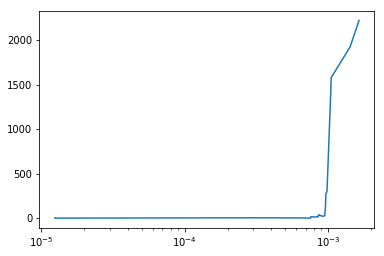

In [45]:
plt.xscale('log')
plt.plot(fin_pgr,features)
plt.show()

In [9]:
sorted_pgr = sorted(pagerank.items(), key=operator.itemgetter(1), reverse = True)
sp_keys = [float(b) for (a,b) in sorted_pgr]
print(len(sp_keys) != len(set(sp_keys)))

True


In [60]:
print(sp_keys)

[9711200, 9802150, 9407087, 9802109, 9908142, 9905111, 9610043, 9906064, 9408099, 9510017, 9503124, 9711162, 9510209, 9611050, 9510135, 9410167, 9601029, 9401139, 9204099, 9409089, 9412184, 9602022, 9803131, 9603142, 9411149, 9210010, 106048, 9711165, 9602052, 9405029, 9306002, 9710046, 9412228, 9603167, 9301042, 9611230, 9608024, 9703166, 9912072, 9910053, 9612115, 9703030, 9501068, 204253, 9508143, 109162, 9408074, 9602043, 9510169, 9602070, 9402002, 9512062, 9204064, 9512077, 9506171, 9802067, 9401153, 9607201, 9204083, 3190, 9803002, 101126, 9810188, 9511030, 9509066, 9512059, 202021, 9802042, 9704080, 9505105, 9202057, 9402044, 9504090, 9904207, 9507158, 9507121, 9304154, 9411048, 9301068, 9812219, 7170, 9805114, 110055, 12062, 9402032, 9206084, 9201056, 9903205, 9809039, 2034, 9802183, 9802051, 3160, 9306153, 9205068, 9212149, 9804058, 9601038, 9304011, 9211021, 9303046, 9909134, 9805170, 9603161, 9612121, 9511222, 9611042, 9712251, 204089, 2245, 9206070, 9710009, 9207016, 980608

##### beware, they are quite long to compute each

In [3]:
def compute_page_rank_feature_for_authors(citation_set, node_info, G=None):
    if G != G:
        G = graph_authors(citation_set, node_info)
        bool = True
    else:
        bool = False
    
    pg_rk = nx.pagerank(G)
    pg_rk_features = []
    for citation in citation_set:
        source = citation[0]
        target = citation[1]
        
        index_source = IDs.index(source)
        index_target = IDs.index(target)
        
        source_authors = [element[3].split(",") for element in node_info if element[0]==source][0]
        target_authors = [element[3].split(",") for element in node_info if element[0]==target][0]
        
        feature = 0
        for auth in source_authors + target_authors:
            feature += pg_rk[auth]
        
        pg_rk_features.append(feature)
    
    if bool:
        return np.array(pg_rk_features), G
    else:
        return np.array(pg_rk_features)

In [26]:
def compute_rich_club_feature_for_articles(citation_set, G=None):
    if G != G:
        G = graph_articles(citation_set)
        bool = True
    else:
        bool = False
    
    rc_cl = nx.richclub.rich_club_coefficient(G)
    
    rc_cl_features = []
    for citation in citation_set:
        rc_cl_features.append(rc_cl[citation[0]] + rc_cl[citation[1]])
    
    if bool:
        return np.array(rc_cl_features), G
    else:
        return np.array(rc_cl_features)

In [25]:
def compute_rich_club_feature_for_authors(citation_set, node_info, G=None):
    if G != G:
        G = graph_authors(citation_set, node_info)
        bool = True
    else:
        bool = False
    
    rc_cl = nx.richclub.rich_club_coefficient(G)
    rc_cl_features = []
    for citation in citation_set:
        source = citation[0]
        target = citation[1]
        
        index_source = IDs.index(source)
        index_target = IDs.index(target)
        
        source_authors = [element[3].split(",") for element in node_info if element[0]==source][0]
        target_authors = [element[3].split(",") for element in node_info if element[0]==target][0]
        
        feature = 0
        for auth in source_authors + target_authors:
            feature += rc_cl[auth]
        
        rc_cl_features.append(feature)
    
    if bool:
        return np.array(rc_cl_features), G
    else:
        return np.array(rc_cl_features)

In [16]:
def compute_shorthest_path_feature_for_articles(citation_set,G=None):
    if G != G:
        G = graph_articles(citation_set)
        bool = True
    else:
        bool = False
    
    sht_pth_features = []
    for citation in citation_set:
        if citation[2] == '1':
            G.remove_edge(citation[0], citation[1])
        sht_pth_features.append(
                nx.shortest_path_length(G,citation[0], citation[1]) if nx.has_path(G, citation[0], citation[1]) else 30)
        if citation[2] == '1':
            G.add_edge(citation[0], citation[1])
    
    if bool:
        return np.array(sht_pth_features), G
    else:
        return np.array(sht_pth_features)